0 - Import of libaries

In [1]:
import pandas as pd
import geopandas as gpd
import importlib
import requests

from shapely.geometry import Point
import matplotlib.pyplot as plt

c:\Users\0davi\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:154: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\0davi\AppData\Local\Temp\ipykernel_18204\1172264417.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [2]:
import av_potential_utils as av
importlib.reload(av)

<module 'av_potential_utils' from 'c:\\Users\\0davi\\github\\CSET_AV_Chile\\av_potential_utils.py'>

In [3]:
# Configuration
crs = 32719                 # For measurements in m
crs_illustration = 4326     # For illustration purposes, the most recognizable CRS


1 - Import of data and data perparation

1.1 Chile map

In [4]:
# import of shapefile of Chilean continental regions 
gdf_cl = gpd.read_file("data\\Chile_regions_conti.shp").to_crs(epsg = crs) 
gdf_cl = gdf_cl.rename(columns={'REGION': 'region'})

# Exclude Magallanes y de la Antártica Chilena (no potential + high computing time)
gdf_cl = gdf_cl[gdf_cl["region"] != "Magallanes y de la Antártica Chilena"] 

# Set to a specific region for regional analisis
region =  "Metropolitana de Santiago"
if region is not None:
    gdf_cl = gdf_cl[gdf_cl["region"] == region]

gdf_cl.to_file("processed\\gdf_cl_rm.shp")
gdf_cl

,CUT_REG,region,SUPERFICIE,geometry
11,13,Metropolitana de Santiago,15401.94,"POLYGON ((331378.254 6241505.224, 333949.502 6..."


1.2 - Land use clases

In [5]:
# Land use clases
gdf_cs = gpd.read_file("data\\clase_uso_suelo\\clase_suelo_RM.shp").to_crs(epsg = crs) 
gdf_cs["land_class"] = gdf_cs["textcaus"] 
av.get_area_shp(gdf_cs,unit="ha",column_name="area")
gdf_cs = gdf_cs[["land_class","area", "geometry"]]
# gdf_cs = gdf_cs[gdf_cs["land_class"].isin(['I', 'II', 'III', 'IV', 'V','VI','VII'])]  # Eclude non classified soil
gdf_cs.to_file("processed\\gdf_cs_rm.shp")
gdf_cs.head(3)

,land_class,area,geometry
0,II,545.78,"POLYGON ((303956.214 6261298.376, 303963.970 6..."
1,VII,4698.23,"POLYGON ((293516.736 6242445.581, 293542.142 6..."
2,VII,5850.19,"POLYGON ((287806.975 6252829.538, 287807.944 6..."


1.3 - Agricultural Areas

In [6]:
# Fruticultural Areas
gdf_fruti = gpd.read_file("data\\catastro_fruticulture\\Región Metropolitana de Santiago_poly.shp").to_crs(epsg = crs) 
av.get_area_shp(gdf_fruti,unit="ha",column_name="area")
gdf_fruti["area_of"] = gdf_fruti["SUPERFICIE"]
gdf_fruti["agri_type"] = "permanent crops"
gdf_fruti["crop"] = gdf_fruti["ESPECIE"]
gdf_fruti["region"] = gdf_fruti["IDENTIFICA"]
gdf_fruti["id"] = gdf_fruti.index
gdf_fruti = gdf_fruti[["id","agri_type","crop","region","area","geometry"]]
area_fruti_original = gdf_fruti["area"].sum().round(2)
print("The total area of the fruticultural ground is "+str(area_fruti_original)+" ha")

# Overlay with land use class
gdf_fruti_overlay = gpd.overlay(gdf_fruti, gdf_cs[["land_class","geometry"]], how='intersection')
av.get_area_shp(gdf_fruti_overlay,unit="ha",column_name="area")
area_fruti = gdf_fruti_overlay["area"].sum()
print("After overlay, the total area of the fruticultural ground is "+str(area_fruti)+" ha, difference of "+str((area_fruti-area_fruti_original).round(2))+" ha") 
gdf_fruti = gdf_fruti_overlay[["id","land_class","agri_type","crop","region","area","geometry"]]
gdf_fruti = gdf_fruti.sort_values(by='id')
gdf_fruti = gdf_fruti.reset_index(drop=True)
gdf_fruti

The total area of the fruticultural ground is 58686.37 ha
After overlay, the total area of the fruticultural ground is 58431.91 ha, difference of -254.46 ha


,id,land_class,agri_type,crop,region,area,geometry
0,0,I,permanent crops,NOGAL,Región Metropolitana de Santiago,1.06,"POLYGON ((335082.198 6261996.047, 335154.824 6..."
1,0,I,permanent crops,NOGAL,Región Metropolitana de Santiago,8.10,"POLYGON ((334809.657 6261641.026, 334703.775 6..."
2,1,I,permanent crops,NOGAL,Región Metropolitana de Santiago,7.24,"POLYGON ((334356.469 6261439.923, 334418.856 6..."
3,2,I,permanent crops,NOGAL,Región Metropolitana de Santiago,1.67,"POLYGON ((335525.318 6261732.629, 335521.838 6..."
4,2,I,permanent crops,NOGAL,Región Metropolitana de Santiago,8.95,"POLYGON ((335651.474 6261541.877, 335514.212 6..."
...,...,...,...,...,...,...,...
19739,12512,I,permanent crops,NOGAL,Región Metropolitana de Santiago,9.02,"POLYGON ((334703.775 6261701.924, 334809.657 6..."
19740,12513,I,permanent crops,NOGAL,Región Metropolitana de Santiago,7.48,"POLYGON ((334877.667 6261221.888, 334955.543 6..."
19741,12514,I,permanent crops,NOGAL,Región Metropolitana de Santiago,7.24,"POLYGON ((334883.845 6261598.182, 334927.406 6..."
19742,12515,I,permanent crops,NOGAL,Región Metropolitana de Santiago,7.04,"POLYGON ((335298.428 6261406.525, 335280.621 6..."


In [7]:
# Agricultural Areas
gdf_conaf = gpd.read_file("data\\catastro_conaf\\13__regi_n_metropolitana_2013.shp").to_crs(epsg = crs) 

#gdf_conaf = gdf_conaf[['USO', 'SUBUSO', 'ESTRUCTURA', 'COBERTURA', 'CODREG','NOM_REG',
#       'NOM_COM10','NOM_PRO10', 'SUPERF_HA','geometry']]
        
gdf_agri = gdf_conaf[gdf_conaf['USO']=='TERRENOS AGRICOLAS']            # Filter for agricultural areas
av.get_area_shp(gdf_agri,unit="ha")
area_agri_original = gdf_agri["area"].sum()
print("The total area of the agricultural ground is "+str(area_agri_original)+" ha")
gdf_agri["agri_type"] = "arable land"
gdf_agri["area_of"] = gdf_agri["SUPERF_HA"]
gdf_agri["crop"] = gdf_agri["SUBUSO"]
gdf_agri["region"] = gdf_agri["NOM_REG"]

gdf_agri = gdf_agri[["agri_type","crop","region","area","geometry"]]

# Cut out fruticulture orchard areas
gdf_agri["area_old"] = gdf_agri["area"].copy()
gdf_agri_cut = gpd.overlay(gdf_agri, gdf_fruti, how='difference')
av.get_area_shp(gdf_agri_cut,unit="ha")
area_agri = gdf_agri_cut["area"].sum()
print("After cutting fruticultural ground, the total area of the agricultural ground is "+str(area_agri)+" ha, difference of "+str(area_agri-area_agri_original)+" ha")
# Filter reduced and very small areas in gdf
#filter_criteria = 0.3
#print("The gdf_agri has "+str(len(gdf_agri))+" entries")
#gdf_agri_cut = gdf_agri_cut[1/gdf_agri_cut["area_old"]*gdf_agri_cut["area"]>filter_criteria]
#print("The gdf_agri has "+str(len(gdf_agri_cut))+" entries after filtering for reduced areas")
#gdf_agri_cut = gdf_agri_cut[gdf_agri_cut["area"]>0.1]
#print("The gdf_agri has "+str(len(gdf_agri_cut))+" entries after filtering for areas smaller than 0.1 ha")

# Clean columns
gdf_agri = gdf_agri_cut.reset_index(drop=True)
gdf_agri["id"] = gdf_agri.index
gdf_agri = gdf_agri[["id","agri_type","crop","region","area","geometry"]]
gdf_agri.head(3)

# Overlay with land use class
gdf_agri_overlay = gpd.overlay(gdf_agri, gdf_cs, how='intersection')
av.get_area_shp(gdf_agri_overlay,unit="ha",column_name="area")
area_agri_overlay =gdf_agri_overlay["area"].sum()
print("After overlay, the total area of the agricultural ground is "+str(area_agri_overlay)+" ha, difference of "+str((area_agri_overlay-area_agri).round(2))+" ha") 

gdf_agri = gdf_agri_overlay[["id","land_class","agri_type","crop","region","area","geometry"]]
gdf_agri = gdf_agri.sort_values(by='id')
gdf_agri = gdf_agri.reset_index(drop=True)
gdf_agri.head(3)

The total area of the agricultural ground is 219103.02000000002 ha
After cutting fruticultural ground, the total area of the agricultural ground is 164307.19 ha, difference of -54795.830000000016 ha
After overlay, the total area of the agricultural ground is 163218.61000000002 ha, difference of -1088.58 ha


,id,land_class,agri_type,crop,region,area,geometry
0,0,II,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,14.98,"POLYGON ((309080.000 6272410.000, 309079.020 6..."
1,0,VI,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,2.50,"MULTIPOLYGON (((309060.000 6272450.000, 309060..."
2,1,IV,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,4.99,"POLYGON ((314175.041 6271648.169, 314179.990 6..."


In [8]:
gdf_agri_fruti = pd.concat([gdf_agri,gdf_fruti])
gdf_agri_fruti = gdf_agri_fruti.reset_index(drop=True)
gdf_agri_fruti["id"] = gdf_agri_fruti.index
gdf_agri_fruti.to_file("processed\\gdf_agri_rm.shp")
gdf_agri_fruti.head(3)

,id,land_class,agri_type,crop,region,area,geometry
0,0,II,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,14.98,"POLYGON ((309080.000 6272410.000, 309079.020 6..."
1,1,VI,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,2.50,"MULTIPOLYGON (((309060.000 6272450.000, 309060..."
2,2,IV,arable land,TERRENOS DE USO AGRICOLA,Region Metropolitana de Santiago,4.99,"POLYGON ((314175.041 6271648.169, 314179.990 6..."


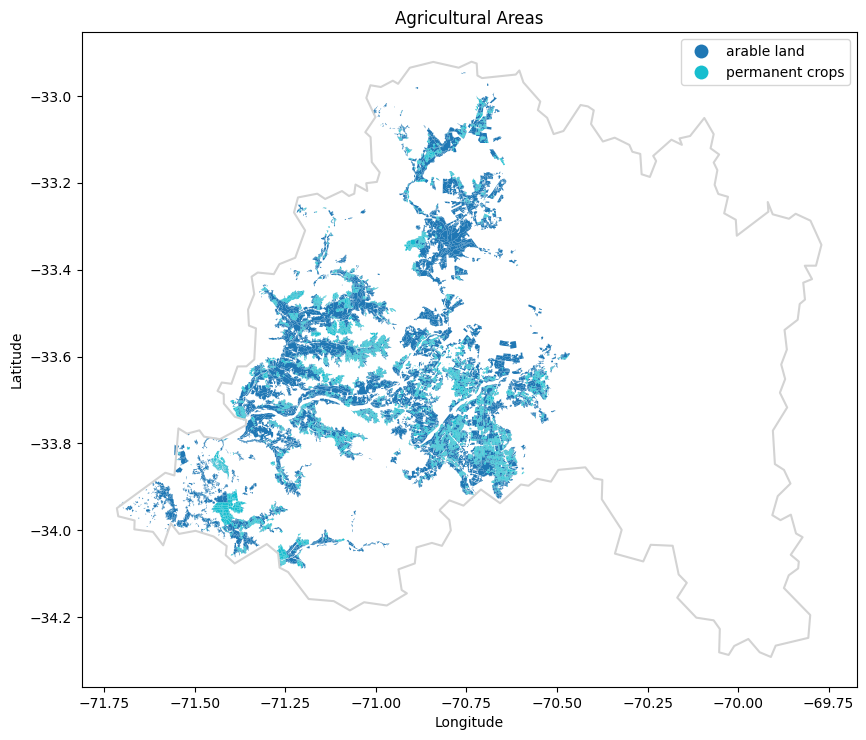

In [9]:
# Plot shapefile of Chilean regions and dataset with berries area
ax = gdf_agri_fruti.to_crs(crs_illustration).plot(figsize=(10, 10), column='agri_type', legend=True)
gdf_cl.to_crs(crs_illustration).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Agricultural Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

1.4 - Precipitation

In [10]:
gdf_preci = gpd.read_file("data\\CR2_preci\\EC_mapa.shp").set_crs(4326)
gdf_preci = gdf_preci.sjoin(gdf_cl.to_crs(4326), how='inner', predicate='within')
gdf_preci = gdf_preci.rename(columns={'VALOR': 'preci_mm'})
gdf_preci = gdf_preci[['preci_mm','nombre','codigo_esta', 'nombre_cuen','altura','geometry']]
len(gdf_preci)

46

In [11]:
gdf_preci_a = gpd.read_file("data\\CR2_preci_anom\\EC_mapa.shp").set_crs(4326)
gdf_preci_a = gdf_preci_a.rename(columns={'VALOR': 'preci_a_mm'})
gdf_preci_m = pd.merge(gdf_preci, gdf_preci_a[['preci_a_mm','codigo_esta']], on='codigo_esta')
gdf_preci_m = gdf_preci_m.to_crs(epsg = crs) 
gdf_preci_m.to_file("processed\\gdf_preci_rm.shp")
gdf_preci_m

,preci_mm,nombre,codigo_esta,nombre_cuen,altura,geometry,preci_a_mm
0,314.6,Fundo Las Bateas,05733010,Rio Maipo,810,POINT (331141.684 6353118.462),-3.1
1,282.6,Rincon De Los Valles,05733006,Rio Maipo,955,POINT (336078.510 6353168.630),-7.7
2,545.2,Caleu,05733007,Rio Maipo,1120,POINT (313789.960 6346360.678),-3.9
3,354.5,Rungue Embalse,05733008,Rio Maipo,700,POINT (321778.782 6344944.881),-7.8
4,393.0,Cerro Calan,05730012,Rio Maipo,848,POINT (357084.149 6303866.899),-10.0
5,390.7,Quebrada Ramon,05730014,Rio Maipo,730,POINT (357359.901 6299678.668),0.0
6,327.5,Los Panguiles,05744002,Rio Maipo,190,POINT (311703.135 6298253.514),-4.4
7,297.3,Terraza Oficinas Centrales Dga,05730016,Rio Maipo,560,POINT (347160.780 6297770.324),-13.1
8,375.6,Ibacache Alto,05744003,Rio Maipo,169,POINT (288047.640 6293203.189),-4.8
9,429.9,Antupiren,05730013,Rio Maipo,904,POINT (359136.308 6292651.016),-5.0


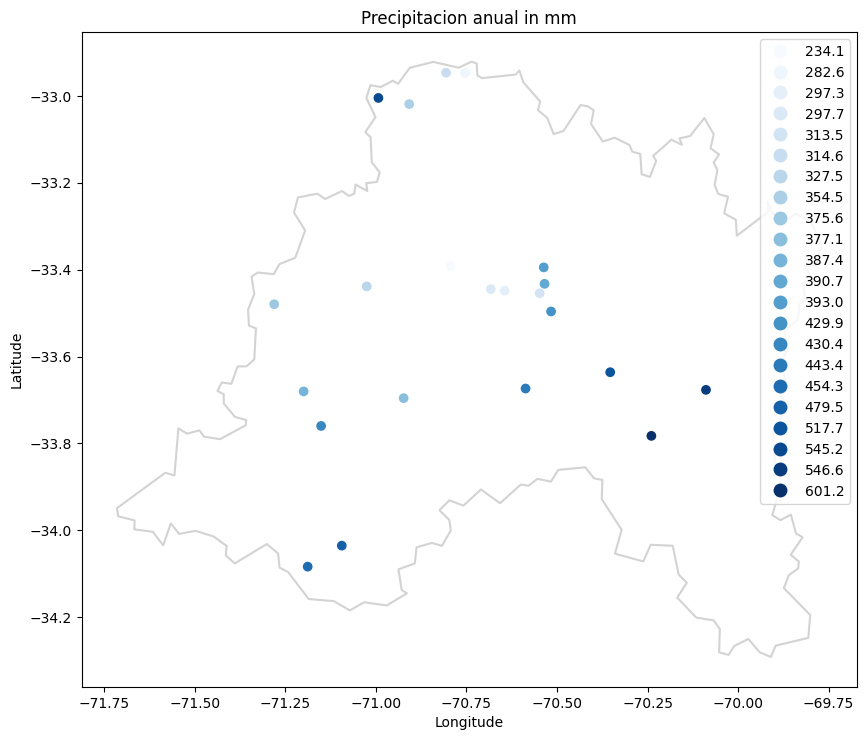

In [12]:
# Plot shapefile of Chilean regions and dataset with berries area
ax = gdf_preci_m.to_crs(crs_illustration).plot(figsize=(10, 10), column='preci_mm', cmap='Blues', legend=True)
gdf_cl.to_crs(crs_illustration).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Precipitacion anual in mm")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

1.5 - Desertification

In [13]:
gdf_des = gpd.read_file("data\\IDE_desertificacion\\desertificacion.shp").to_crs(crs_illustration)
gdf_des = gdf_des.sjoin(gdf_cl.to_crs(4326), how='inner', predicate='intersects')
#gdf_des = gdf_des[gdf_des["id_region"]==13.0]
gdf_des = gdf_des.rename(columns={'rango': 'desert'})
gdf_des = gdf_des[['desert',"geometry"]]
gdf_des = gdf_des.to_crs(epsg = crs) 
gdf_des.to_file("processed\\gdf_desert_rm.shp")
gdf_des.head(3)

,desert,geometry
2195,Urbano *1,"POLYGON ((338108.925 6298871.070, 338303.900 6..."
2226,Moderada,"POLYGON ((369449.951 6343579.805, 369445.765 6..."
2227,Moderada,"POLYGON ((354785.270 6320686.890, 354566.971 6..."


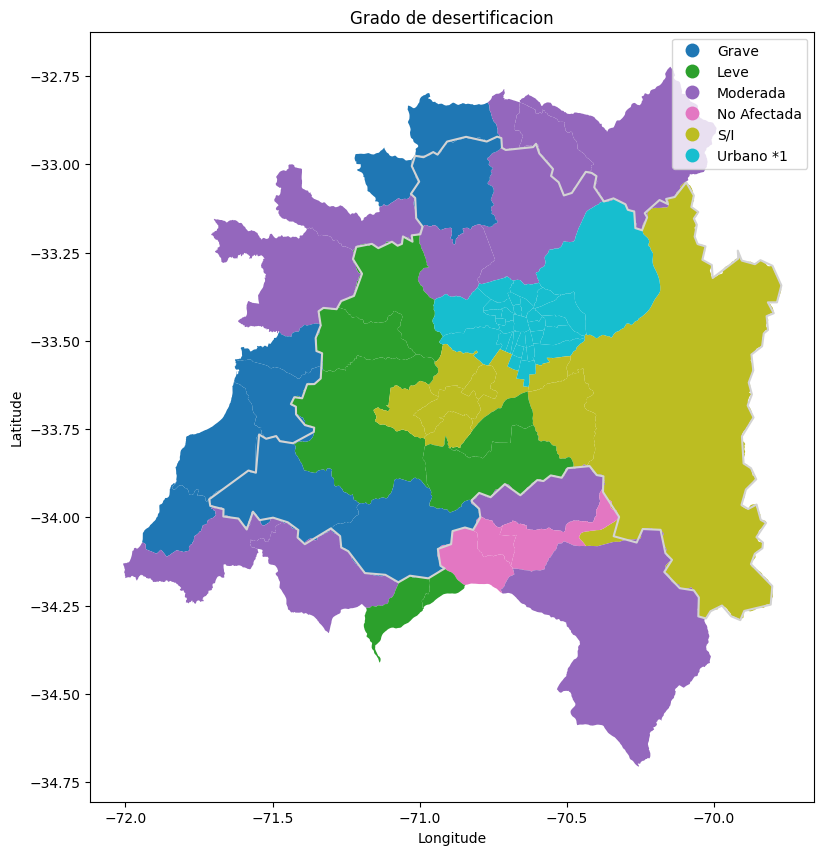

In [14]:
# Plot shapefile of Chilean regions and dataset with berries area
ax = gdf_des.to_crs(crs_illustration).plot(figsize=(10, 10), column='desert', legend=True)
gdf_cl.to_crs(crs_illustration).boundary.plot(ax=ax, edgecolor="lightgrey")

plt.title("Grado de desertificacion")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()